## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)


---

## Task 1: Introduction

## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [1]:
!pip install nlp

In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.17.1


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [3]:
!pip install huggingface_hub
import huggingface_hub

In [4]:
!pip install datasets

In [5]:
import huggingface_hub
from huggingface_hub import hf_hub_download

import datasets

dataset = datasets.load_dataset("emotion")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [60]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [61]:
train = dataset["train"]
val = dataset["validation"]
test = dataset["test"]

In [104]:
label_to_emotion = {0: 'anger', 1: 'joy', 2: 'love', 3: 'surprise', 4: 'fear', 5: 'sadness'}
emotion_to_label = {v: k for k, v in label_to_emotion.items()}

def get_tweet(data):
    tweets = [x['text'] for x in data]
    labels = [x['label'] for x in data]
    return tweets, labels

In [105]:
tweets, labels = get_tweet(train)

In [129]:
train_tweets, train_labels = get_tweet(train)
val_tweets, val_labels = get_tweet(val)
test_tweets, test_labels = get_tweet(test)

In [106]:
tweets[0], labels[0]

('i didnt feel humiliated', 'anger')

In [107]:
tweets[1], labels[1]

('i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'anger')

## Task 4: Tokenizer

1. Tokenizing the tweets

In [108]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=10000, oov_token="<UNK>")
tokenizer.fit_on_texts(tweets)

In [109]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

In [110]:
tweets[0]

'i didnt feel humiliated'

## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

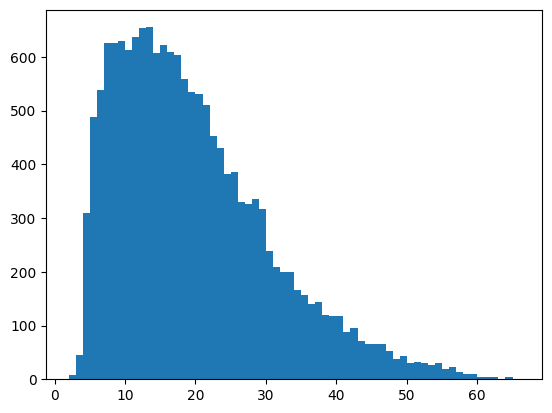

In [111]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [130]:
maxlen = 50

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [134]:
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen)
  return padded

In [135]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [136]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [137]:
classes = set(labels)
print(classes)

{'fear', 'surprise', 'sadness', 'joy', 'anger', 'love'}


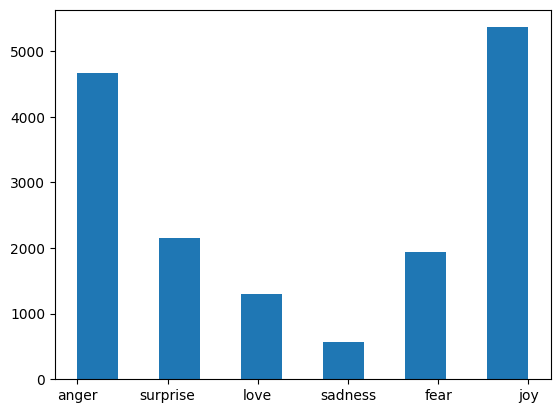

In [138]:
plt.hist(labels,bins=11)
plt.show()

In [181]:
class_to_index = dict((c,i) for i,c in enumerate(classes))
index_to_class = dict((v,k) for k,v in classes_to_index.items())

In [140]:
class_to_index

{'fear': 0, 'surprise': 1, 'sadness': 2, 'joy': 3, 'anger': 4, 'love': 5}

In [141]:
index_to_class

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}

In [142]:
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [143]:
train_labels = names_to_ids(labels)
print(train_labels[0])

4


## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [161]:
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
#     tf.keras.layers.Dense(6, activation='softmax')
# ])

# model.compile(
#     loss='sparse_categorical_crossentropy',
#     optimizer='adam',
#     metrics=['accuracy']
# )

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [182]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(maxlen,)),
    tf.keras.layers.Embedding(10000, 16),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [183]:
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)             │ (None, 50, 16)              │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_20 (Bidirectional)     │ (None, 50, 40)              │           5,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_21 (Bidirectional)     │ (None, 40)                  │           9,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 6)                   │             246 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 175,926 (687.21 KB)

 Trainable params: 175,926 (687.21 KB)

 Non-trainable params: 0 (0.00 B)

## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [184]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [185]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 4)

In [189]:
classes = set(labels)
class_to_index = {c: i for i, c in enumerate(classes)}  # Create class_to_index
index_to_class = {i: c for i, c in enumerate(classes)}  # Create index_to_class

names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])
train_labels = names_to_ids(labels)
padded_train_seq = tf.convert_to_tensor(padded_train_seq, dtype=tf.int32)
train_labels = tf.convert_to_tensor(train_labels, dtype=tf.int32)
val_seq = tf.convert_to_tensor(val_seq, dtype=tf.int32)
val_labels = tf.convert_to_tensor(val_labels, dtype=tf.int32)

h = model.fit(
    padded_train_seq, train_labels,
    validation_data=(val_seq, val_labels),
    epochs=20,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.3869 - loss: 1.5350 - val_accuracy: 0.6100 - val_loss: 1.0199
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.6670 - loss: 0.8716 - val_accuracy: 0.7890 - val_loss: 0.6302
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.8380 - loss: 0.4685 - val_accuracy: 0.8410 - val_loss: 0.5109
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9119 - loss: 0.2750 - val_accuracy: 0.8795 - val_loss: 0.4029
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9396 - loss: 0.1969 - val_accuracy: 0.8755 - val_loss: 0.4234
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9544 - loss: 0.1500 - val_accuracy: 0.8890 - val_loss: 0.3692
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9677 - loss: 0.1071 - val_accuracy: 0.8860 - val_loss: 0.3860
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9691 - loss: 0.1018 - va

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

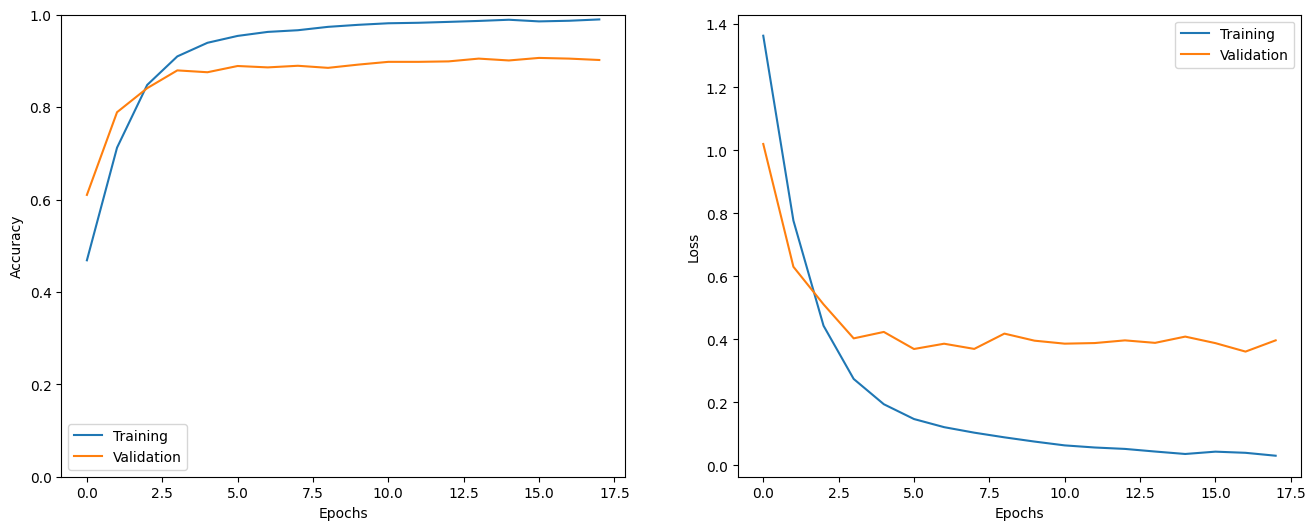

In [190]:
show_history(h)

In [191]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [192]:
_ = model.evaluate(test_seq, test_labels)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8949 - loss: 0.4233


In [193]:
i = random.randint(0, len(test_labels)-1)
print('Sentence:', test_tweets[i])
print('Emotion:', index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]
print('Predicted Emotion:', pred_class)

Sentence: im feeling restless and frustrated right now in that way specific to people who are recovering from illness or injury
Emotion: fear
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
Predicted Emotion: fear


In [194]:
preds = model.predict(test_seq)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


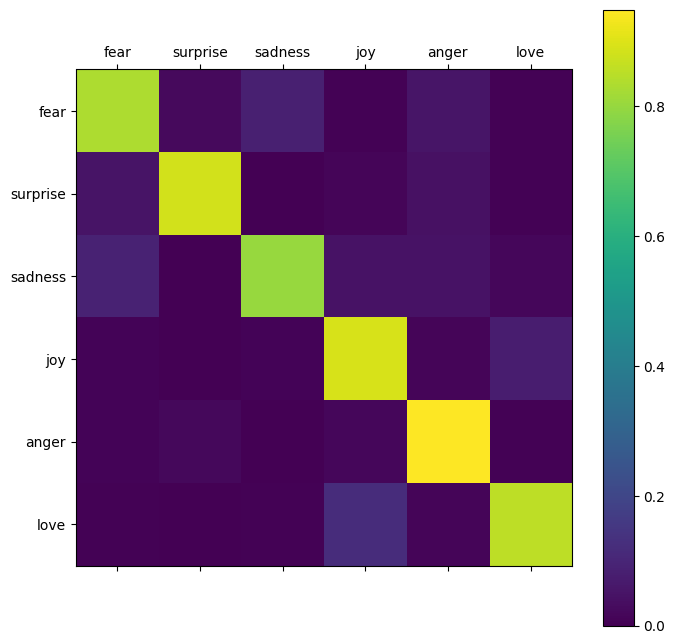

In [195]:
show_confusion_matrix(test_labels, preds.argmax(axis=1), list(classes))